In [1]:
from collections import Counter
import collections
import numpy as np
import scipy.sparse as ss
import Constants

In [2]:
RECALL_TSV = '../data/recall_oriented.tsv'
PRECISION_TSV = '../data/precision_oriented.tsv'
UNIFORM_TSV = '../data/uniformly_sampled.tsv'

RECALL_DATA = '../data/hydrated_recall.json'
PRECISION_DATA = '../data/hydrated_precision.json'
UNIFORM_DATA = '../data/hydrated_uniform.json'

LANG_CODES = '../data/lang_codes.txt'

In [3]:
class DataError(Exception):
    def __init__(self, message):
        self.message = message


class DataManager(object):

    def __init__(self,
                 annotated_tsv=Constants.RECALL_TSV,
                 retrieved_data=Constants.RECALL_DATA,
                 lang_codes_file=Constants.LANG_CODES):
        self.initialized = False
        self.annotated_tsv = annotated_tsv
        self.retrieved_data = retrieved_data
        self.lang_codes_file = lang_codes_file

    def initialize(self, splits=(0.60, 0.20, 0.20), shuffle=True):
        if self.initialized:
            return
        self.lang_codes = self._load_lang_codes()
        self.tweet_labels, self.canonical_inv_idx = \
            self._load_tweet_labels()
        self.tweet_text, self.hydrated_inv_idx = self._load_tweet_text()
        self._split_dataset(splits, shuffle)
        self.initialized = True

    def _split_dataset(self, splits, shuffle):
        if type(splits) not in [list, tuple] or len(splits) != 3:
            err_msg = 'splits should be collection (list or tuple) of length 3'
            raise DataError(err_msg)
        if sum(splits) != 1.0:
            raise DataError('split percentages should sum to 1.0')

        # percentage_split() code source: http://bit.ly/2buzsDm
        def percentage_split(seq, percentages):
            if shuffle:
                np.random.shuffle(seq)
            cdf = np.cumsum(percentages)
            stops = map(int, cdf * len(seq))
            return [seq[a:b] for a, b in zip([0] + stops, stops)]

        self.X_train, self.y_train = [], []
        self.X_dev, self.y_dev = [], []
        self.X_test, self.y_test = [], []
        for lang in self.hydrated_inv_idx:
            if lang not in self.lang_codes:
                continue
            tweet_ids = list(self.hydrated_inv_idx[lang])
            train, dev, test = percentage_split(tweet_ids, splits)
            self.X_train += [self.tweet_text[t] for t in train]
            self.y_train += [lang] * len(train)
            self.X_dev += [self.tweet_text[t] for t in dev]
            self.y_dev += [lang] * len(dev)
            self.X_test += [self.tweet_text[t] for t in test]
            self.y_test += [lang] * len(test)

    def _load_lang_codes(self):
        lang_codes = set()
        with open(self.lang_codes_file) as fp:
            for line in fp:
                lang_codes.add(line.strip())
        return lang_codes

    def _update_inverted_index(self, inv_idx, lang, tweet_id):
        if lang in inv_idx:
            inv_idx[lang].add(tweet_id)
        else:
            inv_idx[lang] = set([tweet_id])
        return inv_idx

    def _load_tweet_labels(self):
        D = {}
        inv_idx = {}
        with open(self.annotated_tsv) as tsv:
            for line in tsv:
                t_lang, t_id = line.strip().split('\t')
                D[t_id] = t_lang
                self._update_inverted_index(inv_idx, t_lang, t_id)
        return D, inv_idx

    def _load_tweet_text(self):
        D = {}
        inv_idx = {}
        with open(self.retrieved_data) as fp:
            for line in fp:
                stripped = line.strip()[2:-2]  # remove quotes and brackets
                t_id, t_text = stripped.split('\",\"')
                D[t_id] = t_text
                self._update_inverted_index(inv_idx,
                                            self.tweet_labels[t_id],
                                            t_id)
        return D, inv_idx

    def training_data(self):
        if not self.initialized:
            raise DataError('Must call initialize() first')
        return self.X_train[:], self.y_train[:]

    def dev_data(self):
        if not self.initialized:
            raise DataError('Must call initialize() first')
        return self.X_dev[:], self.y_dev[:]

    def test_data(self):
        if not self.initialized:
            raise DataError('Must call initialize() first')
        return self.X_test[:], self.y_test[:]

    def hydrated_diff(self):
        if not self.initialized:
            raise DataError('Must call initialize() first')
        for lang in self.lang_codes:
            try:
                diff = (len(self.canonical_inv_idx[lang]) -
                        len(self.hydrated_inv_idx[lang]))
            except KeyError:
                diff = None
            print('{}: {}'.format(lang, diff))


In [4]:
import numpy as np
import scipy.sparse as ss
import sklearn.linear_model
from sklearn.exceptions import NotFittedError
from sklearn.feature_extraction.text import TfidfVectorizer


class Experiment(object):
    '''
    Organize the process of getting data, building a classifier,
    and exploring new representations. Experiment class pattern credit to:
    Matthew Stone, CS 533, Spring 2017 - Classifier Patterns
    '''

    def __init__(self,
                 data_manager,
                 classifier,
                 cleaning_operations,
                 filtering_operations,
                 vectorizer,
                 shuffle=False,
                 seed=None):
        '''set up the problem of learning a classifier from a data manager'''
        self.data_manager = data_manager
        self.classifier = classifier
        self.cleaning_operations = cleaning_operations
        self.filtering_operations = filtering_operations
        self.vectorizer = vectorizer
        self.shuffle = shuffle
        self.seed = seed
        self.initialized = False
        self.validated = False

    def initialize(self):
        '''materialize the training data, dev data and test data as matrices'''
        if self.initialized:
            return
        self.X_train_text, self.y_train_text = \
            self.data_manager.training_data()
        self.X_dev_text, self.y_dev_text = \
            self.data_manager.dev_data()
        self.X_test_text, self.y_test_text = \
            self.data_manager.test_data()
        self._filter()
        self._clean()
        self._extract_features()
        if self.shuffle:
            self._shuffle()
        self.initialized = True

    def _filter(self):
        '''
        The order of the list of operations matters!
        Filtering will remove data!
        '''
        for op in self.filtering_operations:
            if isinstance(op, tuple):
                f = op[0]
                args = op[1]
            else:
                f = op
                args = {}
            self.X_train_text, self.y_train_text = \
                f(self.X_train_text, self.y_train_text, **args)
            self.X_dev_text, self.y_dev_text = \
                f(self.X_dev_text, self.y_dev_text, **args)
            self.X_test_text, self.y_test_text = \
                f(self.X_test_text, self.y_test_text, **args)

    def _clean(self):
        '''
        The order of the list of operations matters! It is recommended to have
            'replace_newline_char' be the first in cleaning_operations.
            Cleaning will not remove data!
        '''
        for op in self.cleaning_operations:
            if isinstance(op, tuple):
                f = op[0]
                args = op[1]
            else:
                f = op
                args = {}
            f(self.X_train_text, self.y_train_text, **args)
            f(self.X_dev_text, self.y_dev_text, **args)
            f(self.X_test_text, self.y_test_text, **args)

    def _extract_features(self):
        '''
        Vectorizer should return NxM matrix where N is number of samples and
            M is number of features (dimension)
        '''
        try:
            self.X_train = self.vectorizer.transform(self.X_train_text)
            print('Using vectorizer fitted elsewhere')
        except NotFittedError:
            self.X_train = self.vectorizer.fit_transform(self.X_train_text)
        self.X_dev = self.vectorizer.transform(self.X_dev_text)
        self.X_test = self.vectorizer.transform(self.X_test_text)

        # TODO: Ensure no zero vectors or any funny business
        S = list(set(self.y_train_text + self.y_dev_text + self.y_test_text))
        self.lang_to_num = dict(zip(S, range(len(S))))
        self.num_to_lang = {v: k for k, v in self.lang_to_num.iteritems()}

        conv = lambda x: self.lang_to_num[x]
        self.y_train = map(conv, self.y_train_text)
        self.y_dev = map(conv, self.y_dev_text)
        self.y_test = map(conv, self.y_test_text)

    def _shuffle(self):
        if self.seed:
            np.random.seed(self.seed)
        p = np.random.permutation(len(self.y_train))
        self.X_train = self.X_train[p]
        self.X_train_text = [self.X_train_text[i] for i in p]
        self.y_train = [self.y_train[i] for i in p]
        self.y_train_text = [self.y_train_text[i] for i in p]

    def stack_features(self, vectorizers):
        if not self.initialized:
            self.initialize()
        for vec in vectorizers:
            s = 'Number of features {} stacking: {}'
            print(s.format('before', self.X_train.shape[1]))
            try:
                self.X_train = \
                    ss.hstack([self.X_train,
                               vec.transform(self.X_train_text)])
                print('Using vectorizer fitted elsewhere')
            except NotFittedError:
                self.X_train = \
                    ss.hstack([self.X_train,
                               vec.fit_transform(self.X_train_text)])
            self.X_dev = \
                ss.hstack([self.X_dev, vec.transform(self.X_dev_text)])
            self.X_test = \
                ss.hstack([self.X_test, vec.transform(self.X_test_text)])
            print(s.format('after', self.X_train.shape[1]))

    def set_classifier(self, classifier):
        if self.validated:
            self.validated = False
        self.classifier = classifier
            
    def fit_and_validate(self):
        '''train the classifier and assess predictions on dev data'''
        if not self.initialized:
            self.initialize()
        if (not hasattr(self.classifier, 'coef_') or
                self.classifier.coef_ is None):
            self.classifier.fit(self.X_train, self.y_train)
        else:
            print('Using classifier fitted elsewhere')

        self.dev_predictions = self.classifier.predict(self.X_dev)
        self.dev_accuracy = \
            sklearn.metrics.accuracy_score(self.y_dev, self.dev_predictions)
        self.validated = True

    def test_results(self):
        ''' Get results from testing data '''
        if not self.initialized:
            self.initialize()
            self.fit_and_validate()
        if not self.validated:
            self.fit_and_validate()
        self.test_predictions = self.classifier.predict(self.X_test)
        self.test_accuracy = \
            sklearn.metrics.accuracy_score(self.y_test, self.test_predictions)


In [48]:
'''
Tromp, E., and M. Pechenizkiy.
"Graph-Based N-gram Language Identification on Short Texts."
Proceedings of the 20th Machine Learning conference of
    Belgium and The Netherlands (2011): 27-34.


Python implementation of Java code found at: https://github.com/ErikTromp/LIGA/
'''

from __future__ import division
import numpy as np

class LIGA(object):
    
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.initialized = False
        
    def _get_ngrams(self, X, n, analyzer, tokenizer):
        ngrams = []
        for t in X:
            if analyzer == 'word':
                t = tokenizer(t) if tokenizer else t.split()
            ngrams.append([t[i:i+n] for i in xrange(len(t)-n+1)])
        return ngrams
    
    def _add_vertices(self, N):
        vertices = {}
        for idx, ngrams in enumerate(N):
            for ngram in ngrams:
                l = self.y_train[idx]
                if ngram not in vertices:
                    vertices[ngram] = {}
                if l not in vertices[ngram]:
                    vertices[ngram][l] = 0
                vertices[ngram][l] += 1
                self.counter[l]['vertices'] += 1
        return vertices
    
    def _add_edges(self, N):
        edges = {k: {} for k in self.vertices}
        for idx, ngrams in enumerate(N):
            l = self.y_train[idx]
            for i in xrange(len(ngrams) - 1):
                src = ngrams[i]
                tar = ngrams[i + 1]
                if tar not in edges[src]:
                    edges[src][tar] = {}
                if l not in edges[src][tar]:
                    edges[src][tar][l] = 0
                edges[src][tar][l] += 1
                self.counter[l]['edges'] += 1
        return edges
    
    def _recursive_path_matching(self, path, scores, curr_depth, max_depth):
        if curr_depth > max_depth or len(path) == 0:
            return scores
        if len(path) == 1:
            ngram = path[0]
            if ngram in self.vertices:
                for l, weight in self.vertices[ngram].iteritems():
                    if l not in scores:
                        scores[l] = 0.0
                    # scores[l] += (weight / self.counter[l]['edges'])
                    scores[l] += (weight / self.counter[l]['vertices'])
            return scores
        src = path[0]
        tar = path[1]
        if src in self.vertices:
            for l, weight in self.vertices[src].iteritems():
                if l not in scores:
                    scores[l] = 0.0
                # scores[l] += (weight / self.counter[l]['edges'])
                scores[l] += (weight / self.counter[l]['vertices'])
            if src in self.edges:
                if tar in self.edges[src]:
                    for l, weight in self.edges[src][tar].iteritems():
                        if l not in scores:
                            scores[l] = 0.0
                        # scores[l] += (weight / self.counter[l]['vertices'])
                        scores[l] += (weight / self.counter[l]['edges'])
        path = path[1:]
        return self._recursive_path_matching(path, scores, curr_depth + 1, max_depth)
        
    def _path_matching(self, ngrams):
        scores = {}
        depth = 0
        max_depth = 1000
        return self._recursive_path_matching(ngrams, scores, depth, max_depth)
    
    def _prediction(self, scores, top_pred):
        if top_pred > len(scores):
            top_pred = len(scores)
        langs = []
        vals = []
        for k, v in scores.iteritems():
            langs.append(k)
            vals.append(v)
        vals = np.array(vals)
        indices = np.argsort(vals)[::-1]
        # top_scores = {}
        top_scores = []
        for i in xrange(top_pred):
            idx = indices[i]
            # top_scores[langs[idx]] = vals[idx]
            top_scores.append((langs[idx], vals[idx]))
        return top_scores

    def initialize(self):
        try:
            decode_unicode(self.X_train, self.y_train)
        except UnicodeEncodeError:
            # already decoded
            pass
        self.counter = {}
        for l in self.y_train:
            if l not in self.counter:
                self.counter[l] = {'vertices': 0, 'edges': 0}
        self.initialized = True

    def learn_model(self, n=2, analyzer='char', tokenizer=None):
        if not self.initialized:
            self.initialize()
        self.n = n
        self.analyzer = analyzer
        self.tokenizer = tokenizer
        N = self._get_ngrams(self.X_train, n, analyzer, tokenizer)
        self.vertices = self._add_vertices(N)
        self.edges = self._add_edges(N)
        
    def classify(self, X_test, top_preds=5):
        N = self._get_ngrams(X_test, self.n, self.analyzer, self.tokenizer)
        pred = []
        for ngrams in N:
            scores = self._path_matching(ngrams)
            if scores:
                top_scores = self._prediction(scores, top_preds)
            else:
                top_scores = [('UNKNOWN', -1.0)]
            pred.append(top_scores)
        return pred
        

In [65]:
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm,
                          classes,
                          normalize=True,
                          title='Confusion matrix',
                          tile_text=False,
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if classes:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)

    if tile_text:
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def show_under_performed(expt, cm, thres=0.50):
    diags = cm.diagonal()
    under_peformed = \
        {expt.num_to_lang[i]: diags[i] for i in np.where(diags < thres)[0]}
    s = '{} / {} underperformed (below {} accuracy)'
    print(s.format(len(under_peformed), len(diags), thres))
    return under_peformed

In [7]:
import re
import string


def decode_unicode(X, y):
    for idx, text in enumerate(X):
        X[idx] = text.decode('utf-8')
    return X, y


def remove_newline_char(X, y):
    for idx, text in enumerate(X):
        X[idx] = text.replace(r'\n', ' ')
    return X, y


def remove_RT(X, y):
    for idx, text in enumerate(X):
        X[idx] = text.replace('RT', '')
    return X, y


def remove_urls(X, y):
    pattern = 'http\S+'
    p = re.compile(pattern)
    for idx, text in enumerate(X):
        if p.search(text):
            X[idx] = p.sub('', text)
    return X, y


def remove_handles(X, y):
    pattern = '@[a-z,A-Z]*'
    p = re.compile(pattern)
    for idx, text in enumerate(X):
        if p.search(text):
            X[idx] = p.sub('', text)
    return X, y


def remove_hashtags(X, y):
    pattern = '#[a-z,A-Z]*'
    p = re.compile(pattern)
    for idx, text in enumerate(X):
        if p.search(text):
            X[idx] = p.sub('', text)
    return X, y


def remove_punctutation(X, y):
    for idx, text in enumerate(X):
        X[idx] = text.translate(None, string.punctuation)
    return X, y


def remove_digits(X, y):
    for idx, text in enumerate(X):
        X[idx] = text.translate(None, string.digits)
    return X, y


def truncate(X, y, trunc_length=140):
    return [text[:trunc_length] for text in X], y


def remove_html_garbage(X,y):
    filt = [r'&lt', r'&gt;', r'&amp;']
    for indx, text in enumerate(X):
        for f in filt:
            text = text.replace(f, '')
        X[indx] = text
    return X, y

def remove_emojis(X, y, emojis):
    for idx, x in enumerate(X):
        for emoji in emojis:
            x = x.replace(emoji, '')
        X[idx] = x
    return X, y


In [8]:
def filt_by_lang(X, y, langs, exclude=False):
    def predicate(lang):
        if exclude:
            return lang not in langs
        return lang in langs

    indices = []
    for idx, lang in enumerate(y):
        if predicate(lang):
            indices.append(idx)
    return [X[i] for i in indices], [y[i] for i in indices]

def filt_long_length(X, y, max_length=140):
    indices = []
    for idx, tweet in enumerate(X):
        if len(tweet) <= max_length:
            indices.append(idx)
    return [X[i] for i in indices], [y[i] for i in indices]

def filt_short_length(X, y, min_length=5):
    indices = []
    for idx, tweet in enumerate(X):
        if len(tweet) >= min_length:
            indices.append(idx)
    return [X[i] for i in indices], [y[i] for i in indices]

def change_lang(X, y):
    for idx, lang in enumerate(y):
        if lang in ['hr', 'sr', 'bs']:
            y[idx] = 'hr'
    return X, y

def by_thres(X, y, n, thres_type='at_least'):
    '''types: at_least, at_most, exactly'''

    if thres_type not in ['at_least', 'at_most', 'exactly']:
        thres_type = 'at_least'

    def predicate(v):
        if thres_type in ['at_least', 'exactly']:
            return v >= n
        return v <= n

    indices = []
    lang_counts = dict(collections.Counter(y))
    lang_counts = {k: v for k, v in lang_counts.iteritems() if predicate(v)}
    if thres_type == 'exactly':
        lang_counts = {k: n for k in lang_counts}
    for idx, lang in enumerate(y):
        if lang in lang_counts:
            if lang_counts[lang] == 0:
                continue
            indices.append(idx)
            lang_counts[lang] -= 1
    return [X[i] for i in indices], [y[i] for i in indices]

In [9]:
dm = DataManager(RECALL_TSV, RECALL_DATA, LANG_CODES)
dm.initialize(shuffle=True, splits=(0.70, 0.15, 0.15))

In [10]:
# X_train, y_train = expt.X_train_text, expt.y_train_text
# liga = LIGA(X_train, y_train)
# liga.learn_model(n=3, analyzer='char')

# X_test, y_test = expt.X_test_text, expt.y_test_text
# scores = liga.classify(X_test, top_preds=3)
# total = len(scores)
# correct = 0
# preds = []
# for idx, score in enumerate(scores):
# #     print y_test[idx], score
#     preds.append(score[0][0])
#     if y_test[idx] == score[0][0]:
#         correct += 1
# print correct / total

In [49]:
max_features = None

vectorizer_word_1 = TfidfVectorizer(sublinear_tf=True,
                                    smooth_idf=True,
                                    ngram_range=(1, 1),
                                    analyzer='word',
                                    max_features=max_features)

vectorizer_word_1_2 = TfidfVectorizer(sublinear_tf=True,
                                    smooth_idf=True,
                                    ngram_range=(1, 2),
                                    analyzer='word',
                                    max_features=max_features)

vectorizer_char_1 = TfidfVectorizer(sublinear_tf=True,
                                    smooth_idf=True,
                                    ngram_range=(1, 1),
                                    analyzer='char',
                                    max_features=max_features)

vectorizer_char_1_2 = TfidfVectorizer(sublinear_tf=True,
                                    smooth_idf=True,
                                    ngram_range=(1, 2),
                                    analyzer='char',
                                    max_features=max_features)

vectorizer_char_1_3 = TfidfVectorizer(sublinear_tf=True,
                                    smooth_idf=True,
                                    ngram_range=(1, 3),
                                    analyzer='char',
                                    max_features=max_features)

vectorizer_char_2 = TfidfVectorizer(sublinear_tf=True,
                                    smooth_idf=True,
                                    ngram_range=(2, 2),
                                    analyzer='char',
                                    max_features=max_features)

vectorizer_char_3 = TfidfVectorizer(sublinear_tf=True,
                                    smooth_idf=True,
                                    ngram_range=(3, 3),
                                    analyzer='char',
                                    max_features=max_features)

classifier_SGD = \
sklearn.linear_model.SGDClassifier(loss="log",
                                   penalty="elasticnet",
                                   n_iter=5)

classifier_KNN = \
    sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)


In [50]:
import cPickle as pickle
with open('../data/emoji_unicode.pkl', 'rb') as f:
    emojis = pickle.load(f)

clean_ops = [
    decode_unicode, remove_newline_char, remove_RT, remove_urls,
    remove_handles, remove_hashtags, remove_html_garbage, (remove_emojis, {'emojis': emojis}), truncate
]

romance_langs = ['es', 'fr', 'pt', 'ro', 'it', 'ca']
slovak_langs = ['sr', 'bs', 'hr']
chinese_langs = ['zh-CN', 'zh-TW']

filter_ops = [
#     (filt_by_lang, {'langs': langs, 'exclude': False}),
    filt_short_length
]

empty_ops = []

In [51]:
expt_word_1 = Experiment(dm,
                         classifier=None,
                         cleaning_operations=clean_ops,
                         filtering_operations=empty_ops,
                         vectorizer=vectorizer_word_1,
                         shuffle=True)

expt_word_1_2 = Experiment(dm,
                         classifier=None,
                         cleaning_operations=clean_ops,
                         filtering_operations=empty_ops,
                         vectorizer=vectorizer_word_1_2,
                         shuffle=True)

expt_char_1 = Experiment(dm,
                         classifier=None,
                         cleaning_operations=clean_ops,
                         filtering_operations=empty_ops,
                         vectorizer=vectorizer_char_1,
                         shuffle=True)

expt_char_1_2 = Experiment(dm,
                         classifier=None,
                         cleaning_operations=clean_ops,
                         filtering_operations=empty_ops,
                         vectorizer=vectorizer_char_1_2,
                         shuffle=True)

expt_char_1_3 = Experiment(dm,
                         classifier=None,
                         cleaning_operations=clean_ops,
                         filtering_operations=empty_ops,
                         vectorizer=vectorizer_char_1_3,
                         shuffle=True)

expt_char_2 = Experiment(dm,
                         classifier=None,
                         cleaning_operations=clean_ops,
                         filtering_operations=empty_ops,
                         vectorizer=vectorizer_char_2,
                         shuffle=True)

expt_char_3 = Experiment(dm,
                         classifier=None,
                         cleaning_operations=clean_ops,
                         filtering_operations=empty_ops,
                         vectorizer=vectorizer_char_3,
                         shuffle=True)


## Stacked Features

In [31]:
# expt_word_char_stack_1 = Experiment(dm,
#                          classifier=classifier_SGD,
#                          cleaning_operations=clean_ops,
#                          filtering_operations=empty_ops,
#                          vectorizer=vectorizer_word_1,
#                          shuffle=True)
# expt_word_char_stack_1.initialize()
# expt_word_char_stack_1.stack_features([vectorizer_char_1])


# expt_word_char_stack_1_2 = Experiment(dm,
#                          classifier=classifier_SGD,
#                          cleaning_operations=clean_ops,
#                          filtering_operations=empty_ops,
#                          vectorizer=vectorizer_word_1_2,
#                          shuffle=True)
# expt_word_char_stack_1_2.initialize()
# expt_word_char_stack_1_2.stack_features([vectorizer_char_1_2])

# expts = [
#     expt_word_char_stack_1,
#     expt_word_char_stack_1_2
# ]

Number of features before stacking: 169673
Number of features after stacking: 176098
Number of features before stacking: 523513
Number of features after stacking: 611095


## General Experiments with SGD

Expt 0
Features: 169673
0.658534214619
Normalized confusion matrix
[[ 0.8579235   0.          0.01639344 ...,  0.          0.          0.        ]
 [ 0.          0.96491228  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.80536913 ...,  0.          0.          0.00671141]
 ..., 
 [ 0.          0.          0.00952381 ...,  0.42857143  0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.91411043  0.        ]
 [ 0.          0.          0.00851064 ...,  0.          0.          0.9106383 ]]


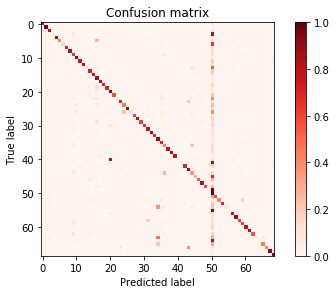

2 / 69 underperformed (below 0.5 accuracy)
{'ko': 0, 'da': 0}
0.671044946454
Normalized confusion matrix
[[ 0.89673913  0.          0.         ...,  0.00543478  0.          0.        ]
 [ 0.          0.97660819  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.84666667 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.00943396 ...,  0.46226415  0.          0.        ]
 [ 0.          0.          0.01226994 ...,  0.          0.85276074  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.89830508]]


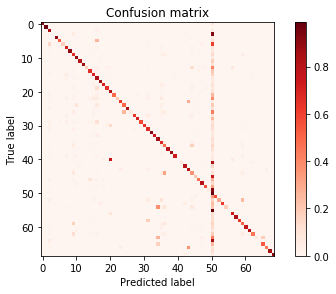

3 / 69 underperformed (below 0.5 accuracy)
{'ug': 0, 'ko': 0, 'da': 0}
Expt 1
Features: 523513
0.607017884914
Normalized confusion matrix
[[ 0.85245902  0.          0.01639344 ...,  0.          0.          0.12021858]
 [ 0.          0.95906433  0.         ...,  0.          0.          0.04093567]
 [ 0.          0.          0.75838926 ...,  0.          0.          0.12080537]
 ..., 
 [ 0.          0.          0.00952381 ...,  0.25714286  0.          0.03809524]
 [ 0.          0.          0.00613497 ...,  0.          0.90797546
   0.06134969]
 [ 0.          0.          0.00425532 ...,  0.          0.          0.97446809]]


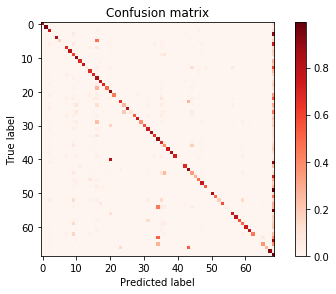

4 / 69 underperformed (below 0.5 accuracy)
{'ug': 0, 'ko': 0, 'ja': 0, 'da': 0}
0.618177205943
Normalized confusion matrix
[[ 0.89130435  0.          0.         ...,  0.          0.          0.09782609]
 [ 0.          0.96491228  0.         ...,  0.          0.          0.02339181]
 [ 0.          0.          0.78666667 ...,  0.          0.          0.1       ]
 ..., 
 [ 0.          0.          0.         ...,  0.27358491  0.          0.0754717 ]
 [ 0.          0.          0.01226994 ...,  0.          0.84662577
   0.13496933]
 [ 0.          0.          0.         ...,  0.          0.          0.97457627]]


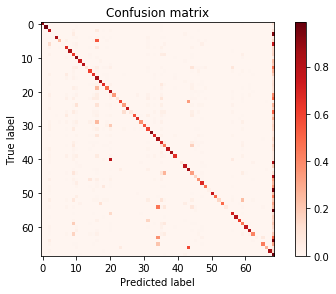

4 / 69 underperformed (below 0.5 accuracy)
{'zh-TW': 0, 'ug': 0, 'ko': 0, 'da': 0}
Expt 2
Features: 6425
0.791796267496
Normalized confusion matrix
[[ 0.99453552  0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.99415205  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.47651007 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.66666667  0.          0.        ]
 [ 0.          0.          0.00613497 ...,  0.          0.98773006  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.94468085]]


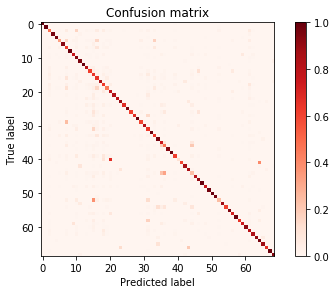

0 / 69 underperformed (below 0.5 accuracy)
{}
0.790980614868
Normalized confusion matrix
[[ 0.99456522  0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.99415205  0.00584795 ...,  0.          0.          0.        ]
 [ 0.          0.          0.52       ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.70754717  0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.98773006  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.96610169]]


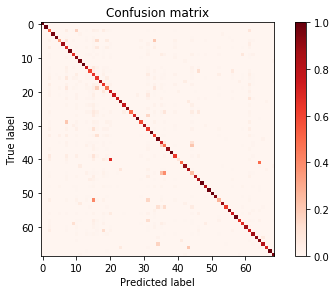

0 / 69 underperformed (below 0.5 accuracy)
{}
Expt 3
Features: 81157
0.848075427683
Normalized confusion matrix
[[ 0.99453552  0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.99415205  0.00584795 ...,  0.          0.          0.        ]
 [ 0.          0.          0.81879195 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.00952381 ...,  0.8         0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.97546012  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.94468085]]


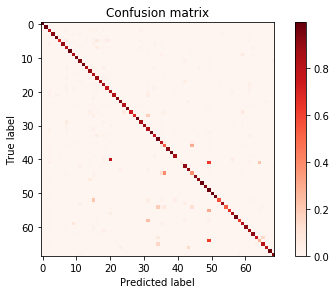

0 / 69 underperformed (below 0.5 accuracy)
{}
0.843252205989
Normalized confusion matrix
[[ 0.98369565  0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.99415205  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.89333333 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.00943396 ...,  0.74528302  0.          0.        ]
 [ 0.          0.          0.00613497 ...,  0.          0.98773006  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.96186441]]


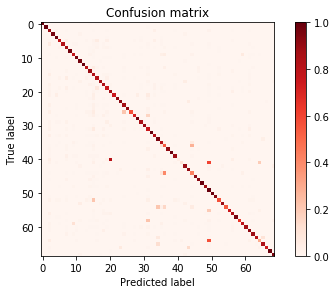

0 / 69 underperformed (below 0.5 accuracy)
{}
Expt 4
Features: 324048
0.789366251944
Normalized confusion matrix
[[ 0.97814208  0.          0.00546448 ...,  0.          0.          0.        ]
 [ 0.          0.99415205  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.80536913 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.00952381 ...,  0.60952381  0.          0.        ]
 [ 0.          0.          0.01226994 ...,  0.          0.95705521  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.96170213]]


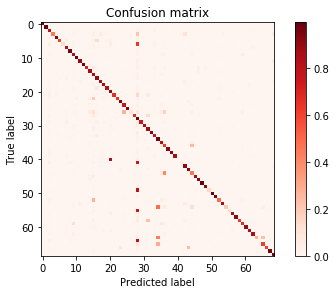

1 / 69 underperformed (below 0.5 accuracy)
{'da': 0}
0.781541615213
Normalized confusion matrix
[[ 0.95652174  0.          0.00543478 ...,  0.          0.          0.        ]
 [ 0.          0.98245614  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.88       ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.00943396 ...,  0.66981132  0.01886792  0.        ]
 [ 0.          0.          0.00613497 ...,  0.          0.95705521  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.94491525]]


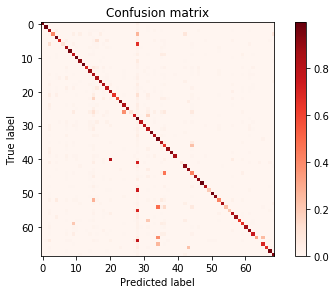

2 / 69 underperformed (below 0.5 accuracy)
{'zh-TW': 0, 'da': 0}
Expt 5
Features: 87582
0.86100311042
Normalized confusion matrix
[[ 0.99453552  0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.99415205  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.81879195 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.80952381  0.          0.        ]
 [ 0.          0.          0.00613497 ...,  0.          0.98773006  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.94468085]]


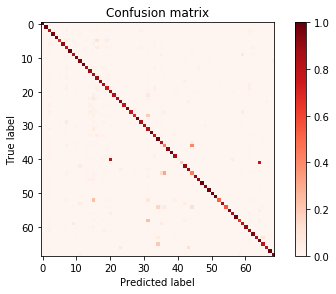

0 / 69 underperformed (below 0.5 accuracy)
{}
0.856097496475
Normalized confusion matrix
[[ 0.98913043  0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.99415205  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.89333333 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.78301887  0.          0.        ]
 [ 0.          0.          0.00613497 ...,  0.          0.98773006  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.96186441]]


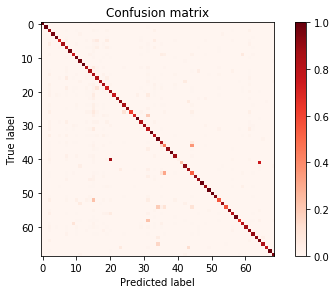

0 / 69 underperformed (below 0.5 accuracy)
{}
Expt 6
Features: 411630
0.857698289269
Normalized confusion matrix
[[ 0.99453552  0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.99415205  0.00584795 ...,  0.          0.          0.        ]
 [ 0.          0.          0.82550336 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.72380952  0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.98159509  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.95319149]]


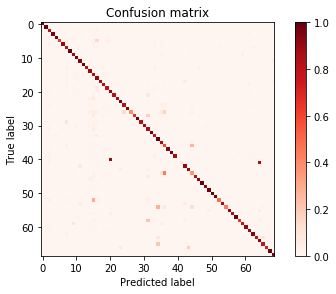

1 / 69 underperformed (below 0.5 accuracy)
{'da': 0}
0.853926235432
Normalized confusion matrix
[[ 0.98913043  0.          0.00543478 ...,  0.          0.          0.        ]
 [ 0.          0.99415205  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.90666667 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.00943396 ...,  0.74528302  0.          0.        ]
 [ 0.          0.          0.00613497 ...,  0.          0.98773006  0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.96186441]]


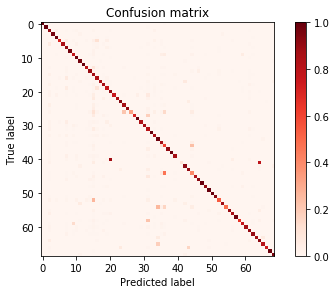

1 / 69 underperformed (below 0.5 accuracy)
{'da': 0}


In [36]:
expts = [
    expt_word_1,
    expt_word_1_2,
    expt_char_1,
    expt_char_2,
    expt_char_3,
    expt_char_1_2,
    expt_char_1_3
]

for idx, expt in enumerate(expts):
    print('Expt {}'.format(idx))
    expt.initialize()
    print('Features: {}'.format(len(expt.vectorizer.get_feature_names())))
    classifier_SGD = \
        sklearn.linear_model.SGDClassifier(loss="log",
                                           penalty="elasticnet",
                                           n_iter=5)
    expt.set_classifier(classifier_SGD)
    
    expt.fit_and_validate()
    print sklearn.metrics.accuracy_score(expt.y_dev, expt.dev_predictions)
    cm = sklearn.metrics.confusion_matrix(expt.y_dev, expt.dev_predictions)
    plt.figure()
    plot_confusion_matrix(cm, [], normalize=True)
    plt.show()
    under_performed = show_under_performed(expt, cm, thres=0.50)
    print under_performed
    
    expt.test_results()
    print sklearn.metrics.f1_score(expt.y_test, expt.test_predictions, average='weighted')
    cm = sklearn.metrics.confusion_matrix(expt.y_test, expt.test_predictions)
    plt.figure()
    plot_confusion_matrix(cm, [], normalize=True)
    plt.show()
    under_performed = show_under_performed(expt, cm, thres=0.50)
    print under_performed

## As a function of max_features

In [39]:
def get_expts(max_features):

    vectorizer_word_1 = TfidfVectorizer(sublinear_tf=True,
                                        smooth_idf=True,
                                        ngram_range=(1, 1),
                                        analyzer='word',
                                        max_features=max_features)

    vectorizer_char_1 = TfidfVectorizer(sublinear_tf=True,
                                        smooth_idf=True,
                                        ngram_range=(1, 1),
                                        analyzer='char',
                                        max_features=max_features)

    vectorizer_char_1_2 = TfidfVectorizer(sublinear_tf=True,
                                        smooth_idf=True,
                                        ngram_range=(1, 2),
                                        analyzer='char',
                                        max_features=max_features)

    vectorizer_char_2 = TfidfVectorizer(sublinear_tf=True,
                                        smooth_idf=True,
                                        ngram_range=(2, 2),
                                        analyzer='char',
                                        max_features=max_features)

    vectorizer_char_3 = TfidfVectorizer(sublinear_tf=True,
                                        smooth_idf=True,
                                        ngram_range=(3, 3),
                                        analyzer='char',
                                        max_features=max_features)

    expt_word_1 = Experiment(dm,
                             classifier=None,
                             cleaning_operations=clean_ops,
                             filtering_operations=empty_ops,
                             vectorizer=vectorizer_word_1,
                             shuffle=True)

    expt_char_1 = Experiment(dm,
                             classifier=None,
                             cleaning_operations=clean_ops,
                             filtering_operations=empty_ops,
                             vectorizer=vectorizer_char_1,
                             shuffle=True)

    expt_char_1_2 = Experiment(dm,
                             classifier=None,
                             cleaning_operations=clean_ops,
                             filtering_operations=empty_ops,
                             vectorizer=vectorizer_char_1_2,
                             shuffle=True)

    expt_char_2 = Experiment(dm,
                             classifier=None,
                             cleaning_operations=clean_ops,
                             filtering_operations=empty_ops,
                             vectorizer=vectorizer_char_2,
                             shuffle=True)

    expt_char_3 = Experiment(dm,
                             classifier=None,
                             cleaning_operations=clean_ops,
                             filtering_operations=empty_ops,
                             vectorizer=vectorizer_char_3,
                             shuffle=True)
    return [expt_word_1, expt_char_1, expt_char_1_2, expt_char_2, expt_char_3]

max_features = [100, 1000, 10000, 100000, None]

for mf in max_features:
    print('Max Features: {}'.format(mf))
    for idx, expt in enumerate(get_expts(mf)): 
        print('Expt {}'.format(idk))
        expt.initialize()
        print('Features: {}'.format(len(expt.vectorizer.get_feature_names())))
        classifier_SGD = \
            sklearn.linear_model.SGDClassifier(loss="log",
                                               penalty="elasticnet",
                                               n_iter=5)
        expt.set_classifier(classifier_SGD)

        expt.fit_and_validate()
        print sklearn.metrics.accuracy_score(expt.y_dev, expt.dev_predictions)
#         cm = sklearn.metrics.confusion_matrix(expt.y_dev, expt.dev_predictions)
#         plt.figure()
#         plot_confusion_matrix(cm, [], normalize=True)
#         plt.show()
#         under_performed = show_under_performed(expt, cm, thres=0.50)
#         print under_performed

#         expt.test_results()
#         print sklearn.metrics.f1_score(expt.y_test, expt.test_predictions, average='weighted')
#         cm = sklearn.metrics.confusion_matrix(expt.y_test, expt.test_predictions)
#         plt.figure()
#         plot_confusion_matrix(cm, [], normalize=True)
#         plt.show()
#         under_performed = show_under_performed(expt, cm, thres=0.50)
#         print under_performed

Max Features: 100
Expt 0
Features: 100
0.235808709176
Expt 0
Features: 100
0.572900466563
Expt 0
Features: 100
0.470353810264
Expt 0
Features: 100
0.386955676516
Expt 0
Features: 100
0.275466562986
Max Features: 1000
Expt 0
Features: 1000
0.542282270607
Expt 0
Features: 1000
0.78217340591
Expt 0
Features: 1000
0.822997667185
Expt 0
Features: 1000
0.774300155521
Expt 0
Features: 1000
0.582328926905
Max Features: 10000
Expt 0
Features: 10000
0.708300933126
Expt 0
Features: 6425
0.789852255054
Expt 0
Features: 10000
0.865765940902
Expt 0
Features: 10000
0.848755832037
Expt 0
Features: 10000
0.81298600311
Max Features: 100000
Expt 0
Features: 100000
0.674475116641
Expt 0
Features: 6425
0.792185069984
Expt 0
Features: 87582
0.861683514774
Expt 0
Features: 81157
0.84749222395
Expt 0
Features: 100000
0.812305598756
Max Features: None
Expt 0
Features: 169673
0.657853810264
Expt 0
Features: 6425
0.792282270607
Expt 0
Features: 87582
0.861877916019
Expt 0
Features: 81157
0.847881026439
Expt 0
Fe

## LIGA

In [52]:
expts = [
    (expt_char_1, 1),
    (expt_char_2, 2),
    (expt_char_3, 3)
]

for expt, n in expts:
    expt.initialize()
    X_train, y_train = expt.X_train_text, expt.y_train_text
    liga = LIGA(X_train, y_train)
    liga.learn_model(n=n, analyzer='char')

    X_test, y_test = expt.X_test_text, expt.y_test_text
    scores = liga.classify(X_test, top_preds=3)
    total = len(scores)
    correct = 0
    preds = []
    for idx, score in enumerate(scores):
    #     print y_test[idx], score
        preds.append(score[0][0])
        if y_test[idx] == score[0][0]:
            correct += 1
    print correct / total

0.531782945736
0.721027131783
0.78265503876


## Confusion Matrix with Word + Char (1-2)-gram Range

In [68]:
vectorizer_word_1_2 = TfidfVectorizer(sublinear_tf=True,
                                    smooth_idf=True,
                                    ngram_range=(1, 2),
                                    analyzer='word',
                                    max_features=max_features)

vectorizer_char_1_2 = TfidfVectorizer(sublinear_tf=True,
                                    smooth_idf=True,
                                    ngram_range=(1, 2),
                                    analyzer='char',
                                    max_features=max_features)

classifier_SGD = \
sklearn.linear_model.SGDClassifier(loss="log",
                                   penalty="elasticnet",
                                   n_iter=5)

romance_langs = ['es', 'fr', 'pt', 'ro', 'it', 'ca']
slovak_langs = ['sr', 'bs', 'hr']
chinese_langs = ['zh-CN', 'zh-TW']

filter_ops = [
    (filt_by_lang, {'langs': slovak_langs, 'exclude': False}),
    filt_short_length
]

expt = Experiment(dm,
                 classifier=classifier_SGD,
                 cleaning_operations=clean_ops,
                 filtering_operations=filter_ops,
                 vectorizer=vectorizer_word_1_2,
                 shuffle=True)
expt.stack_features([vectorizer_char_1_2])
expt.initialize()
expt.fit_and_validate()

Number of features before stacking: 32446
Number of features after stacking: 35064


In [69]:
%matplotlib
num_classes = len(expt.lang_to_num)
print sklearn.metrics.accuracy_score(expt.y_dev, expt.dev_predictions)
cm = sklearn.metrics.confusion_matrix(expt.y_dev, expt.dev_predictions)
plt.figure()
plot_confusion_matrix(cm, [expt.num_to_lang[k] for k in xrange(num_classes)], normalize=True)
plt.show()
under_performed = show_under_performed(expt, cm, thres=0.50)
print under_performed

expt.test_results()
print sklearn.metrics.f1_score(expt.y_test, expt.test_predictions, average='weighted')
cm = sklearn.metrics.confusion_matrix(expt.y_test, expt.test_predictions)
plt.figure()
plot_confusion_matrix(cm, [expt.num_to_lang[k] for k in xrange(num_classes)], normalize=True)
plt.show()
under_performed = show_under_performed(expt, cm, thres=0.50)
print under_performed

Using matplotlib backend: TkAgg
0.668498168498
Normalized confusion matrix
[[ 0.68055556  0.          0.31944444]
 [ 0.08196721  0.75409836  0.16393443]
 [ 0.38461538  0.00961538  0.60576923]]
0 / 3 underperformed (below 0.5 accuracy)
{}
0.685577945003
Normalized confusion matrix
[[ 0.68981481  0.00462963  0.30555556]
 [ 0.13821138  0.76422764  0.09756098]
 [ 0.37980769  0.          0.62019231]]
0 / 3 underperformed (below 0.5 accuracy)
{}


In [78]:
mf_1 = [100, 1000, 10000, 100000, 169673]
acc_1 = [0.2358, 0.5423, 0.7083, 0.6745, 0.6579]

mf_2 = [100, 1000, 6425]
acc_2 = [0.5729, 0.7822, 0.7899]

mf_3 = [100, 1000, 10000, 81157]
acc_3 = [0.387, 0.7743, 0.8488, 0.8475]

mf_4 = [100, 1000, 10000, 100000, 324048]
acc_4 = [0.2755, 0.5823, 0.813, 0.8123, 0.7901]

mf_5 = [100, 1000, 10000, 87582]
acc_5 = [0.4704, 0.823, 0.8658, 0.8617]

In [ ]:
plt.figure()
plt.semilogx(mf_1, acc_1, '--*', label='word - 1')
plt.semilogx(mf_2, acc_2, '--v', label='char - 1')
plt.semilogx(mf_3, acc_3, '--s', label='char - 2')
plt.semilogx(mf_4, acc_4, '--D', label='char - 3')
plt.semilogx(mf_5, acc_5, '--2', label='char - (1, 2)')
plt.title('Accuracy vs Number of Max Features')
plt.xlabel('Number of Max Features')
plt.ylabel('Accuracy')
plt.gca().set_ylim([0.2, 1.0])
plt.legend()
plt.grid()
plt.show()

## Test on Precision Dataset

Using vectorizer fitted elsewhere
9943
(9943, 6427)
Using classifier fitted elsewhere
0.629890375138
[[ 1.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.38210746  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          1.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.74747475  0.          0.        ]
 [ 0.          0.          0.         ...,  0.          1.          0.        ]
 [        nan         nan         nan ...,         nan         nan
          nan]]
{0: 'el', 1: 'en', 2: 'vi', 3: 'ca', 4: 'it', 5: 'cs', 6: 'cy', 7: 'ar', 8: 'eu', 9: 'et', 10: 'id', 11: 'es', 12: 'ru', 13: 'sr', 14: 'nl', 15: 'pt', 16: 'no', 17: 'tr', 18: 'ne', 19: 'lv', 20: 'tl', 21: 'lt', 22: 'th', 23: 'ro', 24: 'is', 25: 'hi-Latn', 26: 'ta', 27: 'fr', 28: 'bg', 29: 'ps', 30: 'hr', 31: 'bn', 32: 'de', 33: 'ht', 34: 'da', 35: 'fa', 36: 'hi', 37: 'bs', 38: 'dv', 39: 'fi', 40: 'hy', 41:

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in divide


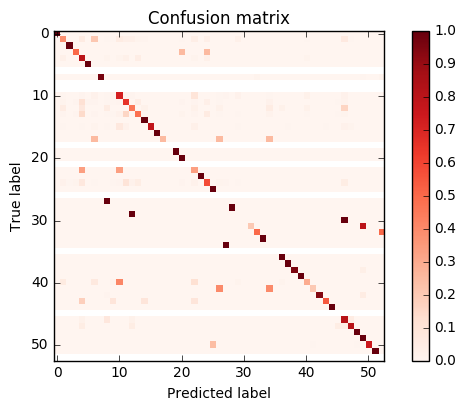

20 / 53 underperformed (below 0.8 accuracy)
['gu', 'ug', 'cy', 'ar', 'ml', 'eu', 'id', 'ps', 'tr', 'lv', 'pa', 'ro', 'is', 'hi-Latn', 'ta', 'bg', 'da', 'zh-CN', 'hi', 'he']
0.6318004208
[[   8    0    0 ...,    0    0    0]
 [   0 1490    2 ...,    0    0    0]
 [   0    0    4 ...,    0    0    0]
 ..., 
 [   0    0    0 ...,  160    0    0]
 [   0    0    0 ...,    0    1    0]
 [   0    0    0 ...,    0    0    0]]
{0: 'el', 1: 'en', 2: 'vi', 3: 'ca', 4: 'it', 5: 'cs', 6: 'cy', 7: 'ar', 8: 'eu', 9: 'et', 10: 'id', 11: 'es', 12: 'ru', 13: 'sr', 14: 'nl', 15: 'pt', 16: 'no', 17: 'tr', 18: 'ne', 19: 'lv', 20: 'tl', 21: 'lt', 22: 'th', 23: 'ro', 24: 'is', 25: 'hi-Latn', 26: 'ta', 27: 'fr', 28: 'bg', 29: 'ps', 30: 'hr', 31: 'bn', 32: 'de', 33: 'ht', 34: 'da', 35: 'fa', 36: 'hi', 37: 'bs', 38: 'dv', 39: 'fi', 40: 'hy', 41: 'hu', 42: 'ja', 43: 'he', 44: 'zh-TW', 45: 'ko', 46: 'sv', 47: 'km', 48: 'ur', 49: 'sk', 50: 'zh-CN', 51: 'si', 52: 'pl', 53: 'uk', 54: 'sl', 55: 'mr'}
Normalized confu

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: RuntimeWarning: invalid value encountered in divide


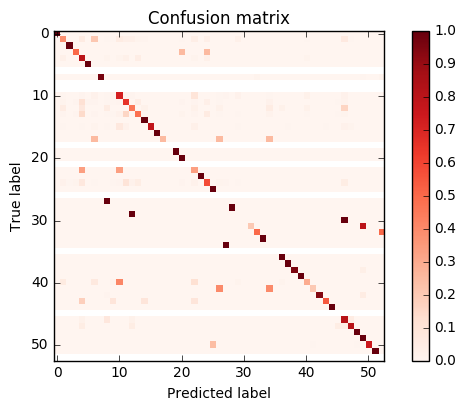

20 / 53 underperformed (below 0.8 accuracy)
['en', 'ca', 'id', 'es', 'ru', 'sr', 'pt', 'tr', 'th', 'is', 'fr', 'ps', 'hr', 'bn', 'de', 'da', 'hy', 'hu', 'he', 'zh-CN']


In [19]:
dm_p = DataManager(UNIFORM_TSV, UNIFORM_DATA, LANG_CODES)
dm_p.initialize(shuffle=True, splits=(0.70, 0.15, 0.15))

vectorizer_p = TfidfVectorizer(sublinear_tf=True,
                             smooth_idf=True,
                             ngram_range=(1, 2),
                             analyzer='char')


# filter_ops = [
#     filt_long_length, filt_short_length,
#     (filt_by_lang, {'langs_to_use': langs_to_use}), (by_thres, {'n': 50, 'thres_type': 'exactly'})
# ]

expt_p = Experiment(dm_p,
                  classifier=classifier,
                  cleaning_operations=clean_ops,
                  filtering_operations=filter_ops,
                  vectorizer=vectorizer,
                  shuffle=True)

expt_p.initialize()

# expt_p.stack_features([vectorizer1])

print len(expt_p.y_dev)
print expt_p.X_dev.shape

conv = lambda x: expt.lang_to_num[x]
expt_p.y_dev = map(conv, expt_p.y_dev_text)
expt_p.fit_and_validate()
print sklearn.metrics.accuracy_score(expt_p.y_dev, expt_p.dev_predictions)

cm_p = sklearn.metrics.confusion_matrix(expt_p.y_dev, expt_p.dev_predictions)
cm_p = cm_p.astype('float') / cm_p.sum(axis=1)[:, np.newaxis]
print cm_p
print expt_p.num_to_lang

plt.figure()
plot_confusion_matrix(cm_p, [expt.num_to_lang[k] for k in xrange(2)], normalize=True)
plt.show()

diags = cm_p.diagonal()
thres = 0.80
under_peformed = [expt.num_to_lang[i] for i in np.where(diags < thres)[0]]
print('{} / {} underperformed (below {} accuracy)'.format(len(under_peformed), len(diags), thres))
print under_peformed

conv = lambda x: expt.lang_to_num[x]
expt_p.y_test = map(conv, expt_p.y_test_text)
expt_p.test_results()
print sklearn.metrics.accuracy_score(expt_p.y_test, expt_p.test_predictions)
print sklearn.metrics.confusion_matrix(expt_p.y_test, expt_p.test_predictions)
print expt_p.num_to_lang

cm_p = sklearn.metrics.confusion_matrix(expt_p.y_dev, expt_p.dev_predictions)
cm_p = cm_p.astype('float') / cm_p.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_p, [expt_p.num_to_lang[k] for k in xrange(2)], normalize=True)
plt.show()

diags = cm_p.diagonal()
thres = 0.80
under_peformed = [expt_p.num_to_lang[i] for i in np.where(diags < thres)[0]]
print('{} / {} underperformed (below {} accuracy)'.format(len(under_peformed), len(diags), thres))
print under_peformed

## t-SNE

In [20]:
import time
from sklearn import manifold, datasets
from sklearn.decomposition import TruncatedSVD

tsne = manifold.TSNE(n_components=2, init='pca', random_state=10)
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
X = svd.fit_transform(expt.X_test)

In [21]:
Y = tsne.fit_transform(X)

In [22]:
%matplotlib
plt.scatter(Y[:, 0], Y[:, 1], c=expt.y_test, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.show()

Using matplotlib backend: TkAgg


In [23]:
print X.shape
print Y.shape

(10320, 50)
(10320, 2)
